# Exploring precision and recall


In [2]:
import pandas as pd
import numpy as np

In [3]:
products = pd.read_csv('amazon_baby.csv')

In [6]:
products

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5
...,...,...,...
183526,Baby Teething Necklace for Mom Pretty Donut Sh...,Such a great idea! very handy to have and look...,5
183527,Baby Teething Necklace for Mom Pretty Donut Sh...,This product rocks! It is a great blend of fu...,5
183528,Abstract 2 PK Baby / Toddler Training Cup (Pink),This item looks great and cool for my kids.......,5
183529,"Baby Food Freezer Tray - Bacteria Resistant, B...",I am extremely happy with this product. I have...,5


In [7]:
products = products.fillna({'review':''})

In [8]:
def remove_punctuation(text):
    import string
    return text.translate(string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)

In [9]:
products = products[products['rating'] != 3]

In [10]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [11]:
train = pd.read_json('./module-9-assignment-train-idx.json')
test = pd.read_json('./module-9-assignment-test-idx.json')

In [16]:
train_data = products.iloc[train[0]]
test_data= products.iloc[test[0]]

In [17]:
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [26]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=300, solver='liblinear')
model.fit(train_matrix, train_set['sentiment'])

LogisticRegression(max_iter=300, solver='liblinear')

In [28]:
accuracy= model.score(test_matrix, test_set['sentiment'])
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9320254379649628


In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy(), y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9320254379649628


In [31]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


In [34]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3783
     -1       |        1        |  1458
      1       |       -1        |   808
      1       |        1        | 27287


In [40]:
VP = 27287
VN = 3783
FP = 1458
FN = 808

In [ ]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.9492781353278831



Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

In [37]:
cost = 1458*100+808*1
cost

146608

In [39]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.9492781353278831


**Quiz Question**: Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)

In [41]:
FP/(FP+VP)

0.05072186467211689

In [42]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Recall on test data: 0.9712404342409682


Quiz Question: What fraction of the positive reviews in the test_set were correctly predicted as positive by the classifier?

In [43]:
VP/(VP+FP)

0.9492781353278831

In [71]:
def apply_threshold(probabilities, threshold):
    predict = np.array([1 if probabilities[i]>=threshold else -1 for i in range(len(probabilities))])
    return predict
    

In [72]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [73]:
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [74]:
print("Number of positive predicted reviews (threshold = 0.5): %s" % (np.array(predictions_with_default_threshold) == 1).astype(int).sum())

Number of positive predicted reviews (threshold = 0.5): 28745


In [75]:
print("Number of positive predicted reviews (threshold = 0.5): %s" % (np.array(predictions_with_high_threshold) == 1).astype(int).sum())

Number of positive predicted reviews (threshold = 0.5): 25055


In [76]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_default_threshold)
                                       

recall_with_default_threshold = recall_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = precision_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_high_threshold)
recall_with_high_threshold = recall_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions_with_high_threshold)

In [77]:
print("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

Precision (threshold = 0.5): 0.9492781353278831
Recall (threshold = 0.5)   : 0.9712404342409682


In [78]:
print("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.9): 0.981281181400918
Recall (threshold = 0.9)   : 0.8751023313756896


In [79]:
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

In [81]:
precision_all = []
recall_all = []

probabilities = model.predict_proba(test_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions)
    recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred=predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

/tmp/ipykernel_17477/1300213809.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')


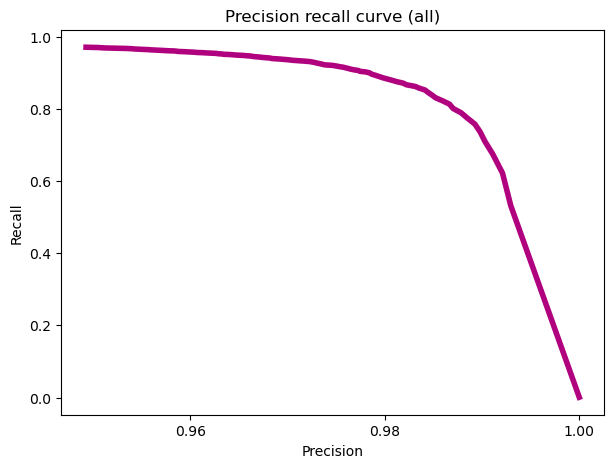

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [85]:
threshold_values[np.array(precision_all)>=0.965][0]

0.7121212121212122

In [88]:
predictions = apply_threshold(probabilities, 0.98)

In [93]:
FN = len(predictions[((predictions == -1) & (test_data['sentiment']==1))])
FN

8189

In [95]:
test_data['name']

0        Baby Tracker&reg; - Daily Childcare Journal, S...
1        Baby Tracker&reg; - Daily Childcare Journal, S...
2           Nature's Lullabies First Year Sticker Calendar
3          Nature's Lullabies Second Year Sticker Calendar
4                              Lamaze Peekaboo, I Love You
                               ...                        
33331    Maxboost iPhone 5S/5 Case - Protective Snap-on...
33332    Maxboost iPhone 5S/5 Case - Protective Snap-on...
33333    Airline Seat Belt Extender - The Best Extensio...
33334    Squeasy Snacker 6oz Silicone Reusable Food Pou...
33335    Best 2 Pack Baby Car Shade for Kids - Window S...
Name: name, Length: 33336, dtype: object

In [97]:
baby_reviews = test_data[test_data['name'].astype(str).apply(lambda x: 'baby' in x.lower())]

In [98]:
baby_reviews

,index,name,review,rating,review_clean,sentiment
0,9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
1,10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1
9,56,Baby's First Year Undated Wall Calendar with S...,I searched high and low for a first year calen...,5,I searched high and low for a first year calen...,1
10,59,Our Baby Girl Memory Book,Absolutely love it and all of the Scripture in...,5,Absolutely love it and all of the Scripture in...,1
13,112,Newborn Baby Tracker&reg; - Round the Clock Ch...,This is the best way to keep track of when you...,5,This is the best way to keep track of when you...,1
...,...,...,...,...,...,...
33314,183406,My Learning Lovey by Baby Jack. Educational ba...,Amazing products come from Baby Jack Blankets!...,5,Amazing products come from Baby Jack Blankets!...,1
33315,183414,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,"My infant goes to a really crappy daycare, and...",-1
33322,183459,Sweet CareFor Bamboo Baby Wipes - 80 Wipe Pack...,"Gave these a try and was impressed! Thick, du...",5,"Gave these a try and was impressed! Thick, du...",1
33325,183465,Swaddle - &quot;Classic&quot; Zen Swaddle - We...,Overall we really like this swaddle; the light...,4,Overall we really like this swaddle; the light...,1


In [99]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [100]:
threshold_values = np.linspace(0.5, 1, num=100)

In [101]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    predictions = apply_threshold(probabilities, threshold)

    
    precision = precision_score(y_true=baby_reviews['sentiment'].to_numpy(),
                                        y_pred=predictions)
    recall = recall_score(y_true=baby_reviews['sentiment'].to_numpy(),
                                        y_pred=predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

In [102]:
threshold_values[np.array(precision_all)>=0.965][0]

0.7474747474747475

/tmp/ipykernel_17477/1300213809.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')


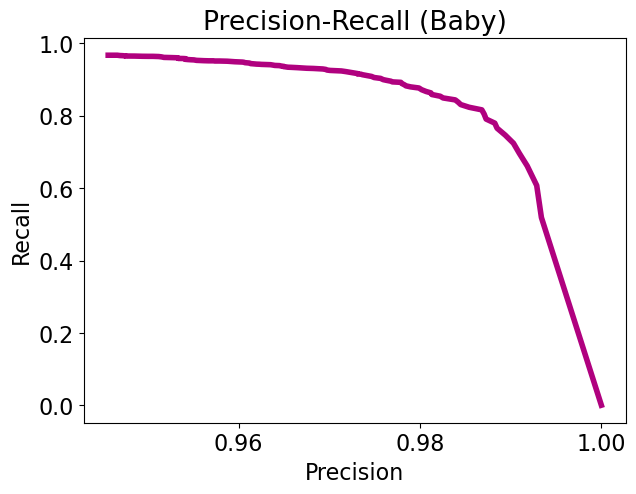

In [103]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")